# XGBoost

In [1]:
import pandas as pd
import numpy as np

## Read dataset

In [2]:
data_train = pd.read_csv('trainset_w_lle.csv')
data_test = pd.read_csv('testset_w_lle.csv')
data_train.head()

,attendance,is_federal_holiday,venue,on_grass,temperature,wind_speed,team1_name,team1_pre_win,team1_pre_loss,team1_pre_win_pct,...,start_hour,start_hour_label_afternoon,start_hour_label_evening,start_hour_label_night,start_hour_label_noon,game_page_url,start_time,previous_5_to_10MA,lle1,lle2
0,35055,0,Wrigley Field,1,-2.786672,-0.093090,STL,-1.62645,-1.654514,0.0,...,19,0,1,0,0,https://www.baseball-reference.com/boxes/CHN/C...,2015-04-05 19:17:00,32742.135802,0.007683,0.000329
1,45030,0,Comerica Park,1,-2.031671,-0.489072,MIN,-1.62645,-1.654514,0.0,...,13,0,0,0,1,https://www.baseball-reference.com/boxes/DET/D...,2015-04-06 13:08:00,36014.925926,0.008566,0.006095
2,45909,0,Safeco Field,1,-1.842921,-1.281036,LAA,-1.62645,-1.654514,0.0,...,13,0,0,0,1,https://www.baseball-reference.com/boxes/SEA/S...,2015-04-06 13:12:00,25485.604938,0.003695,0.009393
3,53518,0,Dodger Stadium,1,-0.804795,-1.281036,SDP,-1.62645,-1.654514,0.0,...,13,0,0,0,1,https://www.baseball-reference.com/boxes/LAN/L...,2015-04-06 13:12:00,46695.518519,0.007517,0.002310
4,48469,0,Yankee Stadium III,1,-1.842921,-0.489072,TOR,-1.62645,-1.654514,0.0,...,13,0,0,0,1,https://www.baseball-reference.com/boxes/NYA/N...,2015-04-06 13:13:00,42520.300000,0.006798,-0.005155


In [3]:
data_train.columns

Index(['attendance', 'is_federal_holiday', 'venue', 'on_grass', 'temperature',
       'wind_speed', 'team1_name', 'team1_pre_win', 'team1_pre_loss',
       'team1_pre_win_pct', 'team1_streak', 'team2_name', 'team2_pre_win',
       'team2_pre_loss', 'team2_pre_win_pct', 'team2_streak', 'salary-500-800',
       'salary-800-1500', 'salary-1500', 'day_Friday', 'day_Monday',
       'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday',
       'day_Wednesday', 'month_April', 'month_August', 'month_July',
       'month_June', 'month_March', 'month_May', 'month_November',
       'month_October', 'month_September', 'weather_Cloudy', 'weather_Drizzle',
       'weather_In Dome', 'weather_Overcast', 'weather_Rain', 'weather_Sunny',
       'season_type', 'season', 'home_team_avg_att_last_year', 'start_hour',
       'start_hour_label_afternoon', 'start_hour_label_evening',
       'start_hour_label_night', 'start_hour_label_noon', 'game_page_url',
       'start_time', 'previous_5_to_10MA', 'lle

In [4]:
from sklearn.preprocessing import StandardScaler
# standardize
number_col = ['previous_5_to_10MA']

# Standardize features by removing the mean and scaling to unit variance.
xscaler = StandardScaler().fit(data_train[number_col])
#standardize feature values
data_train[number_col] = xscaler.transform(data_train[number_col])
data_test[number_col] = xscaler.transform(data_test[number_col])

In [5]:
data_train.drop(['venue', 'start_hour', 'start_time', 'game_page_url'], axis=1, inplace=True)
data_test.drop(['venue', 'start_hour', 'start_time', 'game_page_url'], axis=1, inplace=True)

In [6]:
data_train = pd.get_dummies(data_train, columns=['team1_name', 'team2_name', 'season_type'])
data_test = pd.get_dummies(data_test, columns=['team1_name', 'team2_name', 'season_type'])

In [7]:
train_cols = data_train.columns.tolist()
data_test = data_test[train_cols].copy()

In [8]:
print(set(data_train.columns) - set(data_test.columns))
print(set(data_test.columns) - set(data_train.columns))

set()
set()


In [9]:
data_train.columns

Index(['attendance', 'is_federal_holiday', 'on_grass', 'temperature',
       'wind_speed', 'team1_pre_win', 'team1_pre_loss', 'team1_pre_win_pct',
       'team1_streak', 'team2_pre_win',
       ...
       'team2_name_SDP', 'team2_name_SEA', 'team2_name_SFG', 'team2_name_STL',
       'team2_name_TBR', 'team2_name_TEX', 'team2_name_TOR', 'team2_name_WSN',
       'season_type_post', 'season_type_regular'],
      dtype='object', length=109)

In [10]:
from sklearn.utils import shuffle
data_train = shuffle(data_train)

In [11]:
y_train = data_train['attendance'].to_numpy()
y_test = data_test['attendance'].to_numpy()

data_train.drop(['attendance'], axis=1, inplace=True)
data_test.drop(['attendance'], axis=1, inplace=True)

x_train = data_train.to_numpy()
x_test = data_test.to_numpy()

print(x_train.shape)

(12270, 108)


## kfold

In [12]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [13]:
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
parameters = {'n_estimators': [100, 300, 500, 1000], 'max_depth':[3, 5, 8, 10], 'learning_rate': [0.1, 0.05, 0.01, 0.001], 'colsample_bytree': [0.3, 0.7, 1]}
model = XGBRegressor(random_state=42)
clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1, scoring=scoring, refit='neg_root_mean_squared_error')
clf.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.7, 1],
                         'learning_rate': [0.1, 0.05, 0.01, 0.001],
                         'max_depth': [3, 5, 8, 10],
                         'n_estimators': [100, 300, 500, 1000]},
             refit='neg_root_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error',
                      'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

In [14]:
print("Best estimators:", clf.best_estimator_)
print("Best parameters:", clf.best_params_)

Best estimators: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=8, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)
Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000}


In [15]:
df_res = pd.DataFrame(data=clf.cv_results_)
df_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_neg_mean_squared_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,2.269679,0.089486,0.025791,0.002665,0.3,0.1,3,100,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-2.425527e+07,...,36.183440,116,-0.151206,-0.162221,-0.162909,-0.152774,-0.151575,-0.156137,0.005278,119
1,6.845363,0.249606,0.029762,0.002136,0.3,0.1,3,300,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-2.156413e+07,...,29.587957,96,-0.137124,-0.146534,-0.147467,-0.138006,-0.137893,-0.141405,0.004588,97
2,11.585741,0.335723,0.040869,0.004528,0.3,0.1,3,500,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-2.036101e+07,...,31.240256,83,-0.132052,-0.141476,-0.142775,-0.133560,-0.133338,-0.136640,0.004527,83
3,24.597726,0.572496,0.063271,0.015026,0.3,0.1,3,1000,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-1.903194e+07,...,22.256316,70,-0.127227,-0.137257,-0.136631,-0.128467,-0.128143,-0.131545,0.004431,68
4,3.666557,0.088281,0.033861,0.004056,0.3,0.1,5,100,"{'colsample_bytree': 0.3, 'learning_rate': 0.1...",-2.103318e+07,...,36.522716,92,-0.136794,-0.145933,-0.147362,-0.138993,-0.137425,-0.141302,0.004446,95


## Train with best params

In [16]:
# colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000
xgb = XGBRegressor(colsample_bytree=0.3, learning_rate=0.05, max_depth=8, n_estimators=1000, random_state=42)
xgb = xgb.fit(x_train, y_train)

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
train_predict = xgb.predict(x_train)
print("Train MSE:", mean_squared_error(y_train, train_predict))
print("Train RMSE:", mean_squared_error(y_train, train_predict, squared=False))
print("Train MAE:", mean_absolute_error(y_train, train_predict))
print("Train MAPE:", mean_absolute_percentage_error(y_train, train_predict))

Train MSE: 1056936.3065743684
Train RMSE: 1028.0740764042096
Train MAE: 745.7976958457493
Train MAPE: 0.029333705995687617


Text(0.5, 0, 'Xgboost Feature Importance')

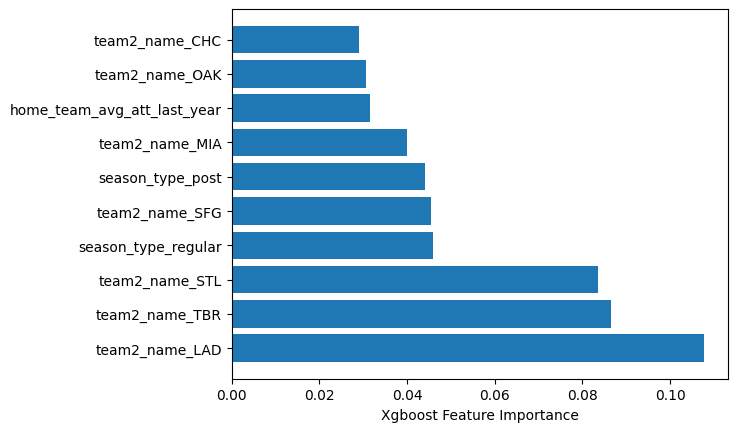

In [18]:
from matplotlib import pyplot as plt
sorted_idx = xgb.feature_importances_.argsort()[::-1]
cols = data_train.columns
plt.barh(cols[sorted_idx][:10], xgb.feature_importances_[sorted_idx][:10])
plt.xlabel("Xgboost Feature Importance")

In [19]:
xgb.feature_importances_[sorted_idx][:10]

array([0.10774267, 0.08652952, 0.08346674, 0.04587775, 0.04555788,
       0.0441349 , 0.04005523, 0.03146826, 0.0307041 , 0.02910312],
      dtype=float32)

## Testing set

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
y_pred = xgb.predict(x_test)
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test MAPE:", mean_absolute_percentage_error(y_test, y_pred))

Test MSE: 35279835.98536661
Test RMSE: 5939.683155301014
Test MAE: 4632.906123186669
Test MAPE: 0.23616716217264272


## Save model

In [21]:
import pickle
from datetime import datetime
time = datetime.today().strftime('%Y%m%d_%H%M%S')
filename = f'./model/xgboost_model_{time}.sav'
pickle.dump(xgb, open(filename, 'wb'))
cv_filename = f'./model/xgboost_model_{time}_cv.csv'
df_res.to_csv(cv_filename, index=False)
# loaded_model = pickle.load(open(filename, 'rb'))